In [1]:
import json
import csv


# read json file containing all corpora
def read_json(filename):
    with open(filename, 'r') as jsonfile:
        data = json.load(jsonfile)
    return data


# get all consecutive spans of similar Tags in one sentence
def sequence(lst):
    seq = []
    for i in range(len(lst)):
        if i == 0 and lst[i] in ['B', 'I']:
            seq.append([(lst[i], i)])
        else:
            if lst[i] == 'O':
                pass
            elif lst[i] in ['B', 'I'] and lst[i - 1] in ['B', 'I']:
                seq[-1].append((lst[i], i))
            else:
                seq.append([(lst[i], i)])
    return seq


# load csv file
def read_csv(filename):
    eval = dict()
    with open(filename, newline='\n') as csvfile:
        data = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in data:
            if len(row) != 4:
                eval[row[1]] = dict()
                temp = ''
                for i in range(2,len(row)):
                    if '[' in row[i]:
                        temp += row[i][3]
                        temp += ' '
                    elif ']' in row[i]:
                        temp += row[i][2]
                        temp += ';'
                    elif "'" in row[i]:
                        temp += row[i][2]
                        temp += ' '
                    else:
                        continue
                predicted_tags = temp.split(';')[0].split(' ')
                gold_tags = temp.split(';')[1].split(' ')
                eval[row[1]]['predicted'] = predicted_tags
                eval[row[1]]['gold'] = gold_tags
            else:
                continue
    return eval


# count True Positives, False Negatives and False Positives
def calc_eval(gold, prediction, tolerance='intersect'):
    # tolerance = intersect, within, none
    # return TP, FN, FP
    checked = []
    tolerance_tracker = 0
    predic_seq = sequence(prediction)
    gold_seq = sequence(gold)
    tp_counter = 0
    fp_counter = 0
    fn_counter = 0
    for g_seq in gold_seq:
        tp = False
        for tag in g_seq:
            if prediction[tag[1]] in ['B', 'I']:
                if g_seq not in checked:
                    tp = True
                    tp_counter += 1
                    checked.append(g_seq)
                else:
                    tolerance_tracker += 1
                break
        if not tp:
            fn_counter += 1
    for p_seq in predic_seq:
        fp = True
        for tag in p_seq:
            if gold[tag[1]] in ['B', 'I']:
                fp = False
                break
        if fp:
            fp_counter += 1
    return tp_counter, fn_counter, fp_counter


def add_params(corpus, spans=False):
    for instance in corpus:
        if spans:
            # add sequences to annotations
            corpus[instance]['gold_spans'] = sequence(corpus[instance]['gold'])
            corpus[instance]['predicted_spans'] = sequence(corpus[instance]['predicted'])

        # calculate tp, fn, fp
        eval_params = calc_eval(corpus[instance]['gold'], corpus[instance]['predicted'])
        corpus[instance]['TP'] = eval_params[0]
        corpus[instance]['FN'] = eval_params[1]
        corpus[instance]['FP'] = eval_params[2]
    return corpus


def evaluate(corpus, beta=1):
    eval = dict()
    tp = 0
    fn = 0
    fp = 0
    for instance in corpus:
        tp += corpus[instance]['TP']
        fn += corpus[instance]['FN']
        fp += corpus[instance]['FP']
    eval['TP'] = tp
    eval['FN'] = fn
    eval['FP'] = fp
    eval['precision'] = tp / (tp + fp)
    eval['recall'] = tp / (tp + fn)
    p = eval['precision']
    r = eval['recall']
    eval['fscore'] = ((beta**2 + 1) * p * r) / (beta**2 * p + r)
    return eval


In [2]:
# VITERBI
# load output files of each viterbi-trained corpus
vit_gne = read_json('markov-gne_trained.json')
vit_eletweets = read_json('markov-electoral_tweets_trained.json')
vit_reman = read_json('markov-reman_trained.json')

# calculate and count tp,fn,fp for each instance (sentence) in each viterbi-trained corpus
vit_gne = add_params(vit_gne)
vit_eletweets = add_params(vit_eletweets)
vit_reman = add_params(vit_reman)

# calculate evaluation for each viterbi-trained corpus
vit_eval_gne = evaluate(vit_gne)
vit_eval_eletweets = evaluate(vit_eletweets)
vit_eval_reman = evaluate(vit_reman)


# RoBERTa
# load output files of each roberta-trained corpus
trans_gne = read_json('roberta-gne-100.json')
trans_eletweets = read_json('roberta-electoral_tweets-100.json')
trans_reman = read_json('roberta-reman-100.json')

# calculate and count tp,fn,fp for each instance (sentence) in each roberta-trained corpus
trans_gne = add_params(trans_gne)
trans_eletweets = add_params(trans_eletweets)
trans_reman = add_params(trans_reman)

# calculate evaluation for each roberta-trained corpus
trans_eval_gne = evaluate(trans_gne)
trans_eval_eletweets = evaluate(trans_eletweets)
trans_eval_reman = evaluate(trans_reman)


print('VITERBI\ntrained on:')
print('\tGNE\n', vit_eval_gne)
print('\n\tElectoral-Tweets:\n', vit_eval_eletweets)
print('\n\tReman:\n', vit_eval_reman)

print('\n\nRoBERTa\ntrained on:')
print('\tGNE\n', trans_eval_gne)
print('\tElectoral-Tweets:\n', trans_eval_eletweets)
print('\n\tReman:\n', trans_eval_reman)

VITERBI
trained on:
	GNE
 {'TP': 2132, 'FN': 1559, 'FP': 5788, 'precision': 0.2691919191919192, 'recall': 0.5776212408561365, 'fscore': 0.3672379639996555}

	Electoral-Tweets:
 {'TP': 4365, 'FN': 1026, 'FP': 11739, 'precision': 0.2710506706408346, 'recall': 0.8096828046744574, 'fscore': 0.4061409630146546}

	Reman:
 {'TP': 6335, 'FN': 1099, 'FP': 11087, 'precision': 0.3636207094478246, 'recall': 0.852165725047081, 'fscore': 0.5097360798197618}


RoBERTa
trained on:
	GNE
 {'TP': 1001, 'FN': 2682, 'FP': 4862, 'precision': 0.17073170731707318, 'recall': 0.27178930219929404, 'fscore': 0.20972134925623298}
	Electoral-Tweets:
 {'TP': 6, 'FN': 5377, 'FP': 5, 'precision': 0.5454545454545454, 'recall': 0.001114620100315809, 'fscore': 0.002224694104560623}

	Reman:
 {'TP': 112, 'FN': 7322, 'FP': 330, 'precision': 0.25339366515837103, 'recall': 0.015065913370998116, 'fscore': 0.028440832910106652}


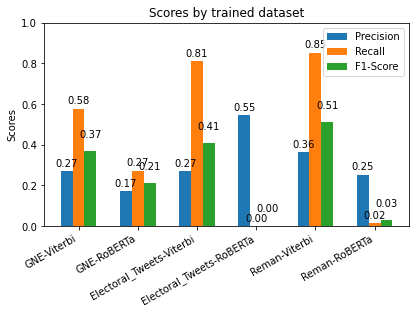

In [3]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['GNE-Viterbi', 'GNE-RoBERTa','Electoral_Tweets-Viterbi', 'Electoral_Tweets-RoBERTa', 'Reman-Viterbi', 'Reman-RoBERTa']
precisions = [vit_eval_gne["precision"], trans_eval_gne["precision"], vit_eval_eletweets["precision"], trans_eval_eletweets["precision"], vit_eval_reman["precision"], trans_eval_reman["precision"]]
recalls = [vit_eval_gne["recall"], trans_eval_gne["recall"], vit_eval_eletweets["recall"], trans_eval_eletweets["recall"], vit_eval_reman["recall"], trans_eval_reman["recall"]]
f1scores = [vit_eval_gne["fscore"], trans_eval_gne["fscore"], vit_eval_eletweets["fscore"], trans_eval_eletweets["fscore"], vit_eval_reman["fscore"], trans_eval_reman["fscore"]]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precisions, width, label='Precision')
rects2 = ax.bar(x , recalls, width, label='Recall')
rects3 = ax.bar(x + width, f1scores, width, label='F1-Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by trained dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def autolabel_higher(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 12),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel_higher(rects3)

plt.ylim(0, 1)

fig.tight_layout()
fig.autofmt_xdate()

plt.savefig("eval.png", transparent=False, pad_inches=0.1,  dpi=500)

plt.show()